In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pylab as plt
import pandas as pd

In [2]:
from pyiron import Project
import pyiron_gpl

In [3]:
pr = Project("validation")
#pr.remove_jobs(recursive=True)

In [4]:
# The list of potentials to iterate over
potential_list = ['Cu_Mendelev_eam', '2004--Zhou-X-W--Cu-Ag-Au--LAMMPS--ipr2', '1985--Foiles-S-M--Ni-Cu--LAMMPS--ipr1']

In [5]:
# Do Murnaghan, ElasticMatrix job, vac formation energy, binding energy, surface energies, comparison with dataset forces, energies

In [6]:
def clean_project_name(name):
    return name.replace("-", "_")

The job murn_job was saved and received the ID: 3880
The job strain_0_9 was saved and received the ID: 3881
The job strain_0_92 was saved and received the ID: 3882
The job strain_0_94 was saved and received the ID: 3883
The job strain_0_96 was saved and received the ID: 3884
The job strain_0_98 was saved and received the ID: 3885
The job strain_1_0 was saved and received the ID: 3886
The job strain_1_02 was saved and received the ID: 3887
The job strain_1_04 was saved and received the ID: 3888
The job strain_1_06 was saved and received the ID: 3889
The job strain_1_08 was saved and received the ID: 3890
The job strain_1_1 was saved and received the ID: 3891
job_id:  3881 finished
job_id:  3882 finished
job_id:  3883 finished
job_id:  3884 finished
job_id:  3885 finished
job_id:  3886 finished
job_id:  3887 finished
job_id:  3888 finished
job_id:  3889 finished
job_id:  3890 finished
job_id:  3891 finished


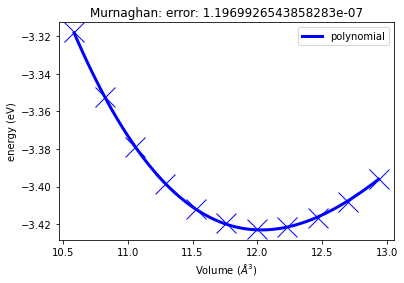

The job murn_job was saved and received the ID: 3892
The job strain_0_9 was saved and received the ID: 3893
The job strain_0_92 was saved and received the ID: 3894
The job strain_0_94 was saved and received the ID: 3895
The job strain_0_96 was saved and received the ID: 3896
The job strain_0_98 was saved and received the ID: 3897
The job strain_1_0 was saved and received the ID: 3898
The job strain_1_02 was saved and received the ID: 3899
The job strain_1_04 was saved and received the ID: 3900
The job strain_1_06 was saved and received the ID: 3901
The job strain_1_08 was saved and received the ID: 3902
The job strain_1_1 was saved and received the ID: 3903
job_id:  3893 finished
job_id:  3894 finished
job_id:  3895 finished
job_id:  3896 finished
job_id:  3897 finished
job_id:  3898 finished
job_id:  3899 finished
job_id:  3900 finished
job_id:  3901 finished
job_id:  3902 finished
job_id:  3903 finished


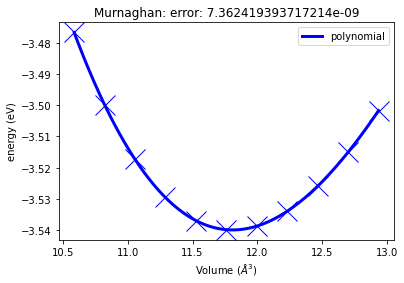

The job murn_job was saved and received the ID: 3904
The job strain_0_9 was saved and received the ID: 3905
The job strain_0_92 was saved and received the ID: 3906
The job strain_0_94 was saved and received the ID: 3907
The job strain_0_96 was saved and received the ID: 3908
The job strain_0_98 was saved and received the ID: 3909
The job strain_1_0 was saved and received the ID: 3910
The job strain_1_02 was saved and received the ID: 3911
The job strain_1_04 was saved and received the ID: 3912
The job strain_1_06 was saved and received the ID: 3913
The job strain_1_08 was saved and received the ID: 3914
The job strain_1_1 was saved and received the ID: 3915
job_id:  3905 finished
job_id:  3906 finished
job_id:  3907 finished
job_id:  3908 finished
job_id:  3909 finished
job_id:  3910 finished
job_id:  3911 finished
job_id:  3912 finished
job_id:  3913 finished
job_id:  3914 finished
job_id:  3915 finished


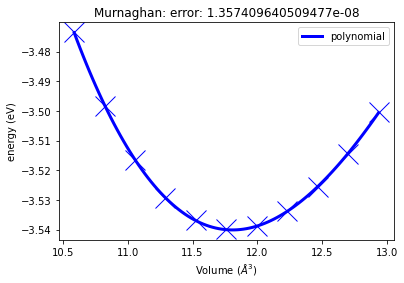

CPU times: user 1min 23s, sys: 54 s, total: 2min 17s
Wall time: 2min 30s


In [7]:
%%time
for pot in potential_list:
    group_name = clean_project_name(pot)
    pr_pot = pr.create_group(pot)
    job_ref = pr_pot.create_job(pr_pot.job_type.Lammps, "ref_job")
    job_ref.structure = pr_pot.create_ase_bulk("Cu")
    job_ref.potential = pot
    job_ref.calc_minimize()
    murn_job = job_ref.create_job(pr_pot.job_type.Murnaghan, "murn_job")
    murn_job.run()
    murn_job.plot()

In [8]:
murn_job["output/equilibrium_energy"]

-3.540132976728019

In [9]:
def get_only_murn(job_table):
    return job_table.hamilton == "Murnaghan"

def get_eq_vol(job_path):
    return job_path["output/equilibrium_volume"]

def get_eq_lp(job_path):
    return np.linalg.norm(job_path["output/structure/cell/cell"][0]) * np.sqrt(2)

def get_eq_bm(job_path):
    return job_path["output/equilibrium_bulk_modulus"]

def get_potential(job_path):
    return job_path["ref_job/input/potential/Name"]

def get_eq_energy(job_path):
    return job_path["output/equilibrium_energy"]

def get_n_atoms(job_path):
    return len(job_path["output/structure/positions"])

In [10]:
%%time
table = pr.create_table("table_murn", delete_existing_job=True)
table.db_filter_function = get_only_murn
table.add["potential"] = get_potential
table.add["a"] = get_eq_lp
table.add["eq_vol"] = get_eq_vol
table.add["eq_bm"] = get_eq_bm
table.add["eq_energy"] = get_eq_energy
table.add["n_atoms"] = get_n_atoms
table.run()
data_murn = table.get_dataframe()
data_murn

  0%|          | 0/3 [00:00<?, ?it/s]

The job table_murn was saved and received the ID: 3916


100%|██████████| 3/3 [00:00<00:00, 13.59it/s]


CPU times: user 359 ms, sys: 266 ms, total: 625 ms
Wall time: 673 ms


,job_id,potential,a,eq_vol,eq_bm,eq_energy,n_atoms
0,3880,Cu_Mendelev_eam,3.637410,12.031420,151.879230,-3.422980,1
1,3892,2004--Zhou-X-W--Cu-Ag-Au--LAMMPS--ipr2,3.614942,11.809844,135.774799,-3.539942,1
2,3904,1985--Foiles-S-M--Ni-Cu--LAMMPS--ipr1,3.614840,11.808844,141.746540,-3.540133,1


In [11]:
%%time
for pot in data_murn.potential.to_list():
    group_name = clean_project_name(pot)
    pr_pot = pr.create_group(pot)
    job_id = int(data_murn[data_murn.potential==pot].job_id)
    job_ref = pr_pot.create_job(pr_pot.job_type.Lammps, "ref_job")
    job_ref.structure = pr_pot.inspect(job_id)["output/structure"].to_object()
    job_ref.potential = pot
    job_ref.calc_minimize()
    elastic_job = job_ref.create_job(pr_pot.job_type.ElasticMatrixJob, "elastic_job")
    elastic_job.run()

The job elastic_job was saved and received the ID: 3917
The job s_e_0 was saved and received the ID: 3918
The job s_01_e_m0_00500 was saved and received the ID: 3919
The job s_01_e_m0_00250 was saved and received the ID: 3920
The job s_01_e_0_00250 was saved and received the ID: 3921
The job s_01_e_0_00500 was saved and received the ID: 3922
The job s_08_e_m0_00500 was saved and received the ID: 3923
The job s_08_e_m0_00250 was saved and received the ID: 3924
The job s_08_e_0_00250 was saved and received the ID: 3925
The job s_08_e_0_00500 was saved and received the ID: 3926
The job s_23_e_m0_00500 was saved and received the ID: 3927
The job s_23_e_m0_00250 was saved and received the ID: 3928
The job s_23_e_0_00250 was saved and received the ID: 3929
The job s_23_e_0_00500 was saved and received the ID: 3930
The job elastic_job was saved and received the ID: 3931
The job s_e_0 was saved and received the ID: 3932
The job s_01_e_m0_00500 was saved and received the ID: 3933
The job s_01_e

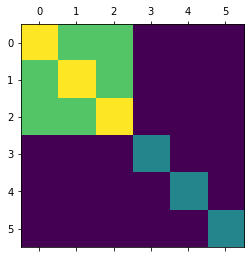

In [12]:
plt.matshow(elastic_job["output/elasticmatrix"]["C"]);

In [13]:
elastic_job["output/elasticmatrix"]["C"].flatten()

array([168.78653632, 123.56991384, 123.56991384,   0.        ,
         0.        ,   0.        , 123.56991384, 168.78653632,
       123.56991384,   0.        ,   0.        ,   0.        ,
       123.56991384, 123.56991384, 168.78653632,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,  76.69333175,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
        76.69333175,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,  76.69333175])

In [14]:
def get_elastic_constants(job_path):
    return job_path["output/elasticmatrix"]["C"].flatten()

def get_only_elastic(job_table):
    return job_table.hamilton == "ElasticMatrixJob"


In [15]:
%%time
table = pr.create_table("table_elastic", delete_existing_job=True)
table.db_filter_function = get_only_elastic
table.add["potential"] = get_potential
table.add["C_list"] = get_elastic_constants
table.run()
data_elastic = table.get_dataframe()
data_elastic

  0%|          | 0/3 [00:00<?, ?it/s]

The job table_elastic was saved and received the ID: 3959


100%|██████████| 3/3 [00:00<00:00,  7.88it/s]


CPU times: user 531 ms, sys: 172 ms, total: 703 ms
Wall time: 861 ms


,job_id,potential,C_list
0,3917,Cu_Mendelev_eam,"[175.61911929994824, 127.95837093157049, 127.95837093157049, 0.0, 0.0, 0.0, 127.95837093157049, 175.61911929994824, 127.95837093157049, 0.0, 0.0, 0.0, 127.95837093157049, 127.95837093157049, 175.6..."
1,3931,2004--Zhou-X-W--Cu-Ag-Au--LAMMPS--ipr2,"[169.92737971608926, 121.8273484849514, 121.8273484849514, 0.0, 0.0, 0.0, 121.8273484849514, 169.92737971608926, 121.8273484849514, 0.0, 0.0, 0.0, 121.8273484849514, 121.8273484849514, 169.9273797..."
2,3945,1985--Foiles-S-M--Ni-Cu--LAMMPS--ipr1,"[168.78653632020246, 123.56991383768599, 123.56991383768599, 0.0, 0.0, 0.0, 123.56991383768599, 168.78653632020246, 123.56991383768599, 0.0, 0.0, 0.0, 123.56991383768599, 123.56991383768599, 168.7..."


In [16]:
# Maybe too complex and intimidating for new python users

elastic_matrix = data_elastic.C_list.apply(pd.Series, index=["c{}{}".format(i, j) for i in range(1, 7) for j in range(1, 7)])

data_elastic_matrix = pd.concat([elastic_matrix, data_elastic], axis=1)
data_elastic_matrix

,c11,c12,c13,c14,c15,c16,c21,c22,c23,c24,...,c56,c61,c62,c63,c64,c65,c66,job_id,potential,C_list
0,175.619119,127.958371,127.958371,0.0,0.0,0.0,127.958371,175.619119,127.958371,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,84.313524,3917,Cu_Mendelev_eam,"[175.61911929994824, 127.95837093157049, 127.95837093157049, 0.0, 0.0, 0.0, 127.95837093157049, 175.61911929994824, 127.95837093157049, 0.0, 0.0, 0.0, 127.95837093157049, 127.95837093157049, 175.6..."
1,169.927380,121.827348,121.827348,0.0,0.0,0.0,121.827348,169.927380,121.827348,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,75.880308,3931,2004--Zhou-X-W--Cu-Ag-Au--LAMMPS--ipr2,"[169.92737971608926, 121.8273484849514, 121.8273484849514, 0.0, 0.0, 0.0, 121.8273484849514, 169.92737971608926, 121.8273484849514, 0.0, 0.0, 0.0, 121.8273484849514, 121.8273484849514, 169.9273797..."
2,168.786536,123.569914,123.569914,0.0,0.0,0.0,123.569914,168.786536,123.569914,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,76.693332,3945,1985--Foiles-S-M--Ni-Cu--LAMMPS--ipr1,"[168.78653632020246, 123.56991383768599, 123.56991383768599, 0.0, 0.0, 0.0, 123.56991383768599, 168.78653632020246, 123.56991383768599, 0.0, 0.0, 0.0, 123.56991383768599, 123.56991383768599, 168.7..."


In [17]:
data_elastic_matrix_short = data_elastic_matrix[['potential', 'c11', 'c12', 'c13', 'c33', 'c44', 'c66']]
data_elastic_matrix_short

,potential,c11,c12,c13,c33,c44,c66
0,Cu_Mendelev_eam,175.619119,127.958371,127.958371,175.619119,84.313524,84.313524
1,2004--Zhou-X-W--Cu-Ag-Au--LAMMPS--ipr2,169.927380,121.827348,121.827348,169.927380,75.880308,75.880308
2,1985--Foiles-S-M--Ni-Cu--LAMMPS--ipr1,168.786536,123.569914,123.569914,168.786536,76.693332,76.693332


In [18]:
%%time

surface_type_list = ["fcc111", "fcc110", "fcc100"]

for i, pot in enumerate(data_murn.potential.to_list()):
    group_name = clean_project_name(pot)
    pr_pot = pr.create_group(group_name)
    a = data_murn.a.to_list()[i]
    for surface_type in surface_type_list:
        surface = pr.create_surface("Cu", surface_type=surface_type, size=(8, 8, 8), a=a, orthogonal=True, vacuum=12)
        job_lammps = pr_pot.create_job(pr_pot.job_type.Lammps, "surf_{}".format(surface_type))
        job_lammps.structure = surface
        job_lammps.potential = pot
        job_lammps.calc_minimize()
        job_lammps.run()

The job surf_fcc111 was saved and received the ID: 3960
The job surf_fcc110 was saved and received the ID: 3961
The job surf_fcc100 was saved and received the ID: 3962
The job surf_fcc111 was saved and received the ID: 3963
The job surf_fcc110 was saved and received the ID: 3964
The job surf_fcc100 was saved and received the ID: 3965
The job surf_fcc111 was saved and received the ID: 3966
The job surf_fcc110 was saved and received the ID: 3967
The job surf_fcc100 was saved and received the ID: 3968
CPU times: user 15.4 s, sys: 12.9 s, total: 28.3 s
Wall time: 21.3 s


In [19]:
pr_pot

{'groups': [], 'nodes': ['surf_fcc111', 'surf_fcc110', 'surf_fcc100']}

In [20]:
surface.plot3d()

NGLWidget()

In [21]:
len(surface) / 8

64.0

In [22]:
pr_pot.job_table().job.str.contains("fcc")

0     False
1     False
2     False
3     False
4     False
5     False
6     False
7     False
8     False
9     False
10    False
11    False
12    False
13    False
14    False
15    False
16    False
17    False
18    False
19    False
20    False
21    False
22    False
23    False
24    False
25    False
26     True
27     True
28     True
Name: job, dtype: bool

In [23]:
def is_a_surface(job_table):
    return (job_table.hamilton == "Lammps") & (job_table.job.str.contains("fcc"))

def get_potential_lammps_job(job_path):
    return job_path["input/potential/Name"]

def get_surface_type(job_path):
    surf_list =  ["fcc111", "fcc110", "fcc100"]
    conditions = [val in job_path.job_name for val in surf_list]
    return surf_list[np.where(conditions)[0].tolist()[0]]

def get_area(job_path):
    cell = job_path["output/structure/cell/cell"]
    return np.linalg.norm(np.cross(cell[0], cell[1]))

In [24]:
get_surface_type(pr_pot.inspect('surf_fcc100'))

'fcc100'

In [25]:
%%time
table = pr.create_table("table_surface", delete_existing_job=True)
table.db_filter_function = is_a_surface
table.add["potential"] = get_potential_lammps_job
table.add["surface_type"] = get_surface_type
table.add["surface_area"] = get_area
table.add.get_total_number_of_atoms

table.add.get_energy_tot
table.run()
data_surf = table.get_dataframe()
data_surf

  0%|          | 0/9 [00:00<?, ?it/s]

The job table_surface was saved and received the ID: 3969


100%|██████████| 9/9 [00:00<00:00, 17.87it/s]


CPU times: user 562 ms, sys: 375 ms, total: 938 ms
Wall time: 1.04 s


,Number_of_atoms,job_id,energy_tot,potential,surface_type,surface_area
0,512,3960,-1705.746713,Cu_Mendelev_eam,fcc111,366.661398
1,512,3961,-1657.007374,Cu_Mendelev_eam,fcc110,598.755556
2,512,3962,-1689.102779,Cu_Mendelev_eam,fcc100,423.384114
3,512,3963,-1744.607843,2004--Zhou-X-W--Cu-Ag-Au--LAMMPS--ipr2,fcc111,362.145737
4,512,3964,-1683.836637,2004--Zhou-X-W--Cu-Ag-Au--LAMMPS--ipr2,fcc110,591.381512
5,512,3965,-1730.881227,2004--Zhou-X-W--Cu-Ag-Au--LAMMPS--ipr2,fcc100,418.169878
6,512,3966,-1762.988823,1985--Foiles-S-M--Ni-Cu--LAMMPS--ipr1,fcc111,362.125297
7,512,3967,-1714.851372,1985--Foiles-S-M--Ni-Cu--LAMMPS--ipr1,fcc110,591.348133
8,512,3968,-1749.588671,1985--Foiles-S-M--Ni-Cu--LAMMPS--ipr1,fcc100,418.146275


In [26]:
data_merged = pd.merge(data_surf, data_murn, on="potential")
data_merged

,Number_of_atoms,job_id_x,energy_tot,potential,surface_type,surface_area,job_id_y,a,eq_vol,eq_bm,eq_energy,n_atoms
0,512,3960,-1705.746713,Cu_Mendelev_eam,fcc111,366.661398,3880,3.637410,12.031420,151.879230,-3.422980,1
1,512,3961,-1657.007374,Cu_Mendelev_eam,fcc110,598.755556,3880,3.637410,12.031420,151.879230,-3.422980,1
2,512,3962,-1689.102779,Cu_Mendelev_eam,fcc100,423.384114,3880,3.637410,12.031420,151.879230,-3.422980,1
3,512,3963,-1744.607843,2004--Zhou-X-W--Cu-Ag-Au--LAMMPS--ipr2,fcc111,362.145737,3892,3.614942,11.809844,135.774799,-3.539942,1
4,512,3964,-1683.836637,2004--Zhou-X-W--Cu-Ag-Au--LAMMPS--ipr2,fcc110,591.381512,3892,3.614942,11.809844,135.774799,-3.539942,1
5,512,3965,-1730.881227,2004--Zhou-X-W--Cu-Ag-Au--LAMMPS--ipr2,fcc100,418.169878,3892,3.614942,11.809844,135.774799,-3.539942,1
6,512,3966,-1762.988823,1985--Foiles-S-M--Ni-Cu--LAMMPS--ipr1,fcc111,362.125297,3904,3.614840,11.808844,141.746540,-3.540133,1
7,512,3967,-1714.851372,1985--Foiles-S-M--Ni-Cu--LAMMPS--ipr1,fcc110,591.348133,3904,3.614840,11.808844,141.746540,-3.540133,1
8,512,3968,-1749.588671,1985--Foiles-S-M--Ni-Cu--LAMMPS--ipr1,fcc100,418.146275,3904,3.614840,11.808844,141.746540,-3.540133,1


In [27]:
data_merged["surface_energy"] = data_merged.energy_tot - (data_merged.eq_energy * data_merged.Number_of_atoms)

In [28]:
data_merged["surface_energy_in_mJ_per_sq_m"] = data_merged.surface_energy / data_merged.surface_area / 2 * 16.0219 * 1e3

In [29]:
data_merged

,Number_of_atoms,job_id_x,energy_tot,potential,surface_type,surface_area,job_id_y,a,eq_vol,eq_bm,eq_energy,n_atoms,surface_energy,surface_energy_in_mJ_per_sq_m
0,512,3960,-1705.746713,Cu_Mendelev_eam,fcc111,366.661398,3880,3.637410,12.031420,151.879230,-3.422980,1,46.819056,1022.919566
1,512,3961,-1657.007374,Cu_Mendelev_eam,fcc110,598.755556,3880,3.637410,12.031420,151.879230,-3.422980,1,95.558395,1278.507591
2,512,3962,-1689.102779,Cu_Mendelev_eam,fcc100,423.384114,3880,3.637410,12.031420,151.879230,-3.422980,1,63.462990,1200.798101
3,512,3963,-1744.607843,2004--Zhou-X-W--Cu-Ag-Au--LAMMPS--ipr2,fcc111,362.145737,3892,3.614942,11.809844,135.774799,-3.539942,1,67.842469,1500.729057
4,512,3964,-1683.836637,2004--Zhou-X-W--Cu-Ag-Au--LAMMPS--ipr2,fcc110,591.381512,3892,3.614942,11.809844,135.774799,-3.539942,1,128.613675,1742.221732
5,512,3965,-1730.881227,2004--Zhou-X-W--Cu-Ag-Au--LAMMPS--ipr2,fcc100,418.169878,3892,3.614942,11.809844,135.774799,-3.539942,1,81.569085,1562.632546
6,512,3966,-1762.988823,1985--Foiles-S-M--Ni-Cu--LAMMPS--ipr1,fcc111,362.125297,3904,3.614840,11.808844,141.746540,-3.540133,1,49.559261,1096.351910
7,512,3967,-1714.851372,1985--Foiles-S-M--Ni-Cu--LAMMPS--ipr1,fcc110,591.348133,3904,3.614840,11.808844,141.746540,-3.540133,1,97.696712,1323.490226
8,512,3968,-1749.588671,1985--Foiles-S-M--Ni-Cu--LAMMPS--ipr1,fcc100,418.146275,3904,3.614840,11.808844,141.746540,-3.540133,1,62.959413,1206.192037


## Finite temperature thermodynamics (Harmonic approximation)

In [30]:
%%time
for pot in data_murn.potential.to_list():
    group_name = clean_project_name(pot)
    pr_pot = pr.create_group(group_name)
    job_id = int(data_murn[data_murn.potential==pot].job_id)
    job_ref = pr_pot.create_job(pr_pot.job_type.Lammps, "ref_job")
    job_ref.structure = pr_pot.inspect(job_id)["output/structure"].to_object()
    job_ref.potential = pot
    job_ref.calc_static()
    phonopy_job = job_ref.create_job(pr_pot.job_type.PhonopyJob, "phonopy_job")
    phonopy_job.run()

The job phonopy_job was saved and received the ID: 3970
The job ref_job_0 was saved and received the ID: 3971
The job phonopy_job was saved and received the ID: 3972
The job ref_job_0 was saved and received the ID: 3973
The job phonopy_job was saved and received the ID: 3974
The job ref_job_0 was saved and received the ID: 3975
CPU times: user 20.3 s, sys: 9.33 s, total: 29.6 s
Wall time: 21.7 s


In [31]:
pr

{'groups': ['1985--Foiles-S-M--Ni-Cu--LAMMPS--ipr1', '1985__Foiles_S_M__Ni_Cu__LAMMPS__ipr1', '2004--Zhou-X-W--Cu-Ag-Au--LAMMPS--ipr2', '2004__Zhou_X_W__Cu_Ag_Au__LAMMPS__ipr2', 'Cu_Mendelev_eam'], 'nodes': ['table_murn', 'table_elastic', 'table_surface']}

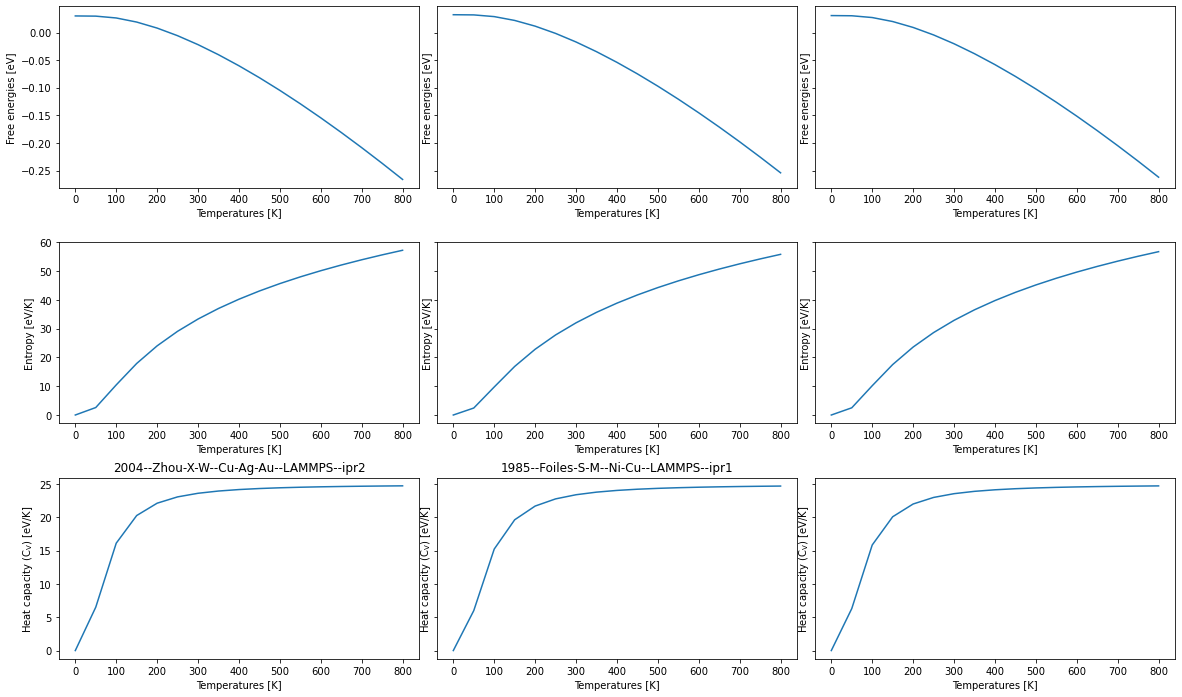

In [35]:
fig, ax_list = plt.subplots(ncols=len(potential_list), nrows=3, sharey="row", sharex="row")
fig.set_figwidth(20)
fig.set_figheight(12)


for i, pot in enumerate(potential_list):
    group_name = clean_project_name(pot)
    ax.set_title(pot)
    phonopy_job = pr[group_name+"/phonopy_job"]
    thermo = phonopy_job.get_thermal_properties(t_min=0, t_max=800)
    
    ax = ax_list[0][i]
    ax.plot(thermo.temperatures, thermo.free_energies)
    ax.set_xlabel("Temperatures [K]")
    ax.set_ylabel("Free energies [eV]")
    
    ax = ax_list[1][i]
    ax.plot(thermo.temperatures, thermo.entropy)
    ax.set_xlabel("Temperatures [K]")
    ax.set_ylabel("Entropy [eV/K]")
    
    ax = ax_list[2][i]
    ax.plot(thermo.temperatures, thermo.cv)
    ax.set_xlabel("Temperatures [K]")
    ax.set_ylabel("Heat capacity (C$_\mathrm{V}$) [eV/K]")
    
fig.subplots_adjust(wspace=0.05, hspace=0.3);    

## **Validating against datasets**

In [36]:
pr_import = Project("../datasets/import_database/Cu_database")

In [37]:
container = pr_import['df1_A1_A2_A3_EV_elast_phon']

In [38]:
training_dataset = container.to_pandas()

In [39]:
training_dataset

,name,atoms,energy,forces,number_of_atoms
0,A1:FHI-aims/PBE/tight:elastic:s_e_0,"(Atom('Cu', [0.0, 0.0, 0.0], index=0))",-3.699843,"[[0.0, 0.0, 0.0]]",1.0
1,A1:FHI-aims/PBE/tight:murnaghan:strain_1_0,"(Atom('Cu', [0.0, 0.0, 0.0], index=0))",-3.699841,"[[0.0, 0.0, 0.0]]",1.0
2,A1:FHI-aims/PBE/tight:phonon:supercell_phonon_0,"(Atom('Cu', [4.3368086899420173e-19, 0.007070999999999999, 0.007070999999999999], index=0), Atom('Cu', [3.3306690738754696e-16, 1.81563, 1.8156300000000005], index=1), Atom('Cu', [7.262518, 10.893...",-236.789603,"[[-1.13852957740976e-06, -0.0464638907314277, -0.0464636807741622], [-3.86335457040412e-06, 0.0124851330231607, 0.0124792943417333], [-1.94300535086066e-06, 6.63943441884098e-05, 6.92790474109119e...",64.0
3,A1:FHI-aims/PBE/tight:murnaghan:strain_1_02,"(Atom('Cu', [0.0, 0.0, 0.0], index=0))",-3.697932,"[[0.0, 0.0, 0.0]]",1.0
4,A1:FHI-aims/PBE/tight:murnaghan:strain_0_98,"(Atom('Cu', [0.0, 0.0, 0.0], index=0))",-3.697559,"[[0.0, 0.0, 0.0]]",1.0
...,...,...,...,...,...
100,A2:FHI-aims/PBE/tight:elastic:s_01_e_0_05000,"(Atom('Cu', [0.0, 0.0, 0.0], index=0))",-3.573436,"[[0.0, 0.0, 0.0]]",1.0
101,A1:FHI-aims/PBE/tight:elastic:s_01_e_m0_05000,"(Atom('Cu', [0.0, 0.0, 0.0], index=0))",-3.546222,"[[0.0, 0.0, 0.0]]",1.0
102,A3:FHI-aims/PBE/tight:elastic:s_01_e_m0_05000,"(Atom('Cu', [1.2150849, 0.70152958, 0.9998186400000001], index=0), Atom('Cu', [0.0, 1.40305917, 2.99945593], index=1))",-7.079448,"[[-3.5446112180968e-23, -1.13427558979097e-22, 0.0], [3.5446112180968e-23, 1.13427558979097e-22, 0.0]]",2.0
103,A2:FHI-aims/PBE/tight:elastic:s_01_e_m0_05000,"(Atom('Cu', [0.0, 0.0, 0.0], index=0))",-3.513068,"[[0.0, 0.0, 0.0]]",1.0


In [40]:
from pyiron import ase_to_pyiron

In [41]:
structure_list =  training_dataset.atoms.apply(ase_to_pyiron).to_list()
energy_list =  training_dataset.energy.to_list()
force_list =  training_dataset.forces.to_list()
num_atoms_list =  training_dataset.number_of_atoms.to_list()

energy_per_atom_list = np.array(energy_list) / np.array(num_atoms_list)


In [42]:
%%time
energy_pred_dict = dict()
force_pred_dict = dict()


for pot in potential_list:
    group_name = clean_project_name(pot)
    pr_pot = pr.create_group(pot)
    energy_pred_list = list()
    force_pred_list = list()
    
    stride = 10
    for i, struct in enumerate(structure_list[::stride]):
        job = pr_pot.create_job(pr.job_type.Lammps, "lammps_struct_{}".format(i))
        job.potential = pot
        job.structure = struct
        job.calc_static()
        job.run()
        energy_pred_list.append(job["output/generic/energy_tot"][-1] / len(struct))
        force_pred_list.append(job["output/generic/forces"][-1])
    job_box = pr_pot.create_job(pr.job_type.Lammps, "lammps_box")
    job_box.potential = pot
    job_box.structure = pr_pot.create_atoms("Cu", scaled_positions=[[0.5, 0.5, 0.5]], cell=np.eye(3)*10, pbc=True)
    job_box.calc_static()
    job_box.run()
    # correct for energy of isolated atom
    energy_pred_list = np.array(energy_pred_list) - job_box["output/generic/energy_tot"][-1]
    energy_pred_dict[pot] = energy_pred_list
    force_pred_dict[pot] = force_pred_list

The job lammps_struct_0 was saved and received the ID: 3976
The job lammps_struct_1 was saved and received the ID: 3977
The job lammps_struct_2 was saved and received the ID: 3978
The job lammps_struct_3 was saved and received the ID: 3979
The job lammps_struct_4 was saved and received the ID: 3980
The job lammps_struct_5 was saved and received the ID: 3981
The job lammps_struct_6 was saved and received the ID: 3982
The job lammps_struct_7 was saved and received the ID: 3983
The job lammps_struct_8 was saved and received the ID: 3984
The job lammps_struct_9 was saved and received the ID: 3985
The job lammps_struct_10 was saved and received the ID: 3986
The job lammps_box was saved and received the ID: 3987
The job lammps_struct_0 was saved and received the ID: 3988
The job lammps_struct_1 was saved and received the ID: 3989
The job lammps_struct_2 was saved and received the ID: 3990
The job lammps_struct_3 was saved and received the ID: 3991
The job lammps_struct_4 was saved and receiv

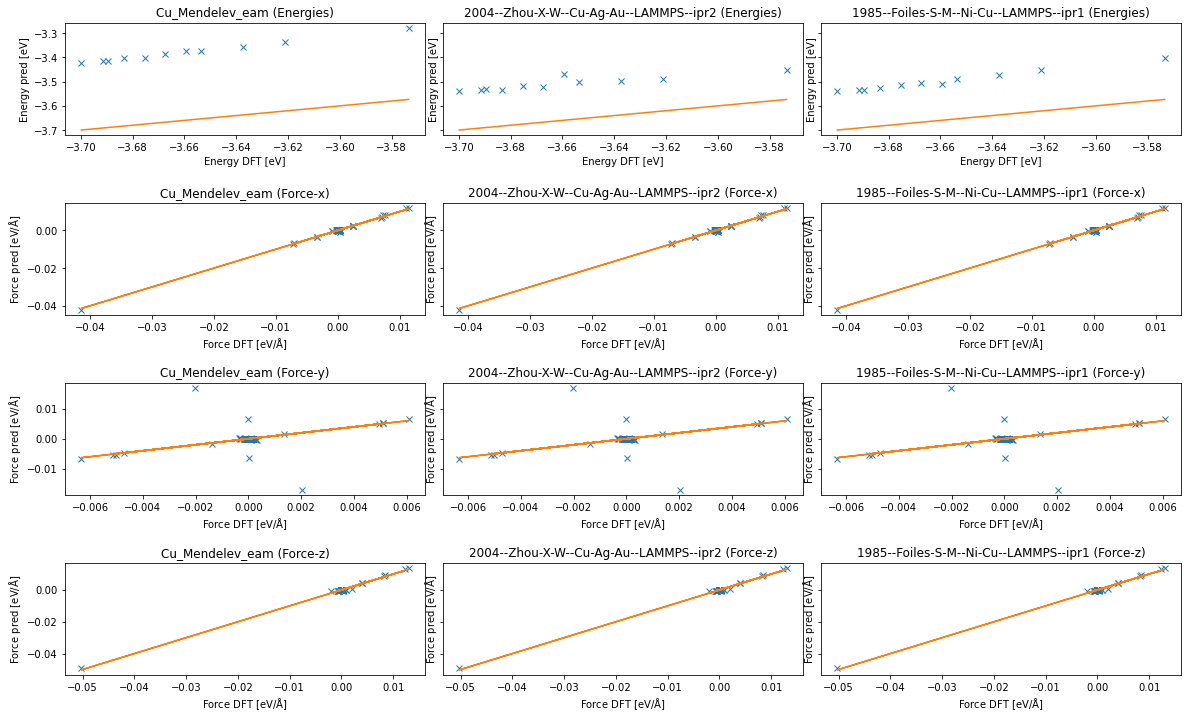

In [43]:
fig, ax_list = plt.subplots(ncols=len(potential_list), nrows=4, sharey="row", sharex="row")
fig.set_figwidth(20)
fig.set_figheight(12)

for i, (pot, energy_pred) in enumerate(energy_pred_dict.items()):
    
    ax = ax_list[0][i]
    ax.plot(energy_per_atom_list[::stride], energy_pred, "x")
    ax.plot(energy_per_atom_list[::stride], energy_per_atom_list[::stride])
    ax.set_title(pot + " (Energies)")
    ax.set_xlabel("Energy DFT [eV]")
    ax.set_ylabel("Energy pred [eV]")
    
    ax = ax_list[1][i]
    force_x_orig = np.hstack([f[:, 0] for f in force_list[::stride]])
    force_x_pred = np.hstack([f[:, 0] for f in force_pred_list])
    ax.plot(force_x_orig, force_x_pred, "x")
    ax.plot(force_x_orig, force_x_orig)
    ax.set_xlabel("Force DFT [eV/$\mathrm{\AA}$]")
    ax.set_ylabel("Force pred [eV/$\mathrm{\AA}$]")
    ax.set_title(pot + " (Force-x)")
    
    ax = ax_list[2][i]
    force_y_orig = np.hstack([f[:, 1] for f in force_list[::stride]])
    force_y_pred = np.hstack([f[:, 1] for f in force_pred_list])
    ax.plot(force_y_orig, force_y_pred, "x")
    ax.plot(force_y_orig, force_y_orig)
    ax.set_xlabel("Force DFT [eV/$\mathrm{\AA}$]")
    ax.set_ylabel("Force pred [eV/$\mathrm{\AA}$]")
    ax.set_title(pot + " (Force-y)")
    
    ax = ax_list[3][i]
    force_z_orig = np.hstack([f[:, 2] for f in force_list[::stride]])
    force_z_pred = np.hstack([f[:, 2] for f in force_pred_list])
    ax.plot(force_z_orig, force_z_pred, "x")
    ax.plot(force_z_orig, force_z_orig)
    ax.set_xlabel("Force DFT [eV/$\mathrm{\AA}$]")
    ax.set_ylabel("Force pred [eV/$\mathrm{\AA}$]")
    ax.set_title(pot + " (Force-z)")
    
fig.subplots_adjust(wspace=0.05, hspace=0.6)
# ax.set_ylim(x_lim)